In [6]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Load Data

In [7]:
df = pd.read_excel('../data/burnside2.xls')
df.rename(columns={'GDPG':'GDP Growth', 
                   'BB':'Budget Surplus',
        'INFL':'Inflation', 'SACW':'Trade Openness', 
        'ETHNF':'Ethnic Frac', 'ASSAS':'Assassinations', 
        'ICRGE':'Institutional Quality', 'M2-1':'L_Money Supply', 'SSA':'Sub-Saharan Africa',
        'EASIA': 'East Asia', 'LPOP':'Log Population', 'EGYPT':'Egypt', 'CENTAM':'Central America', 
        'FRZ':'Franc Zone', 'ARMS-1':'L_Arms NX', 'EDA':'Effective Aid',
        'BEDA':'Bilateral Effective Aid'}, inplace=True)

# Create Groups

In [8]:
country_idx, countries = pd.factorize(df.Country)

# Mean Model

In [74]:
coords = {'country':countries}

with pm.Model(coords=coords) as unpooled:
    fixed_effect = pm.Normal('fixed_effect', mu=0, sigma=1, dims=['country'])
    mu = pm.Deterministic('mu', fixed_effect[country_idx])

    sigma = pm.Exponential('sigma', lam=1)
    gdp_hat = pm.Normal('gdp', mu=mu, sigma=sigma, observed=df.GDPG)

/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pymc/model/core.py:1357: ImputationWarning: Data in gdp contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


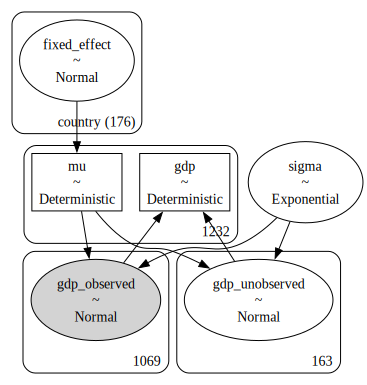

In [75]:
pm.model_to_graphviz(unpooled)

In [76]:
with unpooled:
    idata = pm.sample(init='jitter+adapt_diag_grad')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fixed_effect, sigma, gdp_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


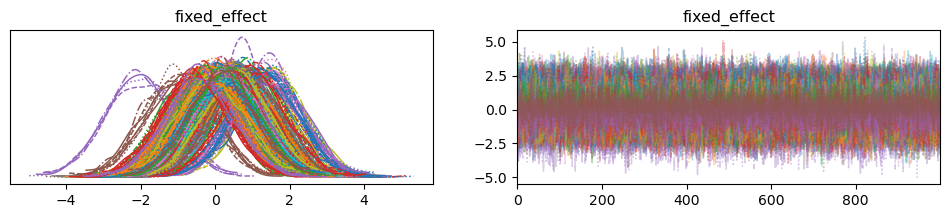

In [77]:
az.plot_trace(idata, var_names=['fixed_effect']);

In [81]:
with unpooled:
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True)

/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x296885460>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [gdp_observed]


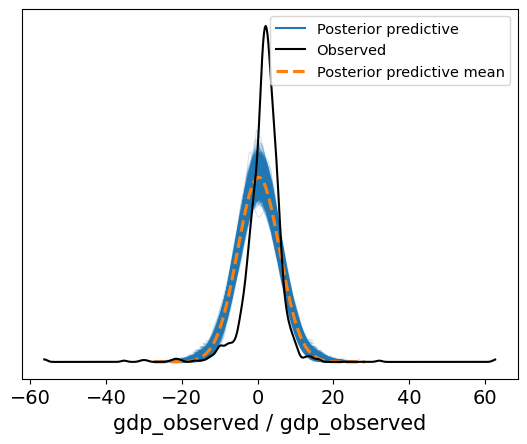

In [82]:
az.plot_ppc(idata);

# Partially Pooled

In [118]:
country_idx, countries = pd.factorize(df.Country3)
year_idx, years = pd.factorize(df.YEAR1)
coords = {
    'country':countries,
    'year':years
}

In [116]:
import seaborn as sns

In [124]:
with pm.Model(coords=coords) as partially_pooled:
    country_effect_mu = pm.Normal('country_effect_mu', mu=0, sigma=1)
    country_effect_sigma = pm.HalfNormal('country_effect_sigma', sigma=1)
    country_effect_offset = pm.ZeroSumNormal('country_effect_offset', sigma=1, dims=['country'])
    country_effect = pm.Deterministic('country_effect', country_effect_mu + country_effect_sigma * country_effect_offset,
                                    dims=['country'])

    # Add time effects
    time_effect = pm.Normal('time_effect', mu=0, sigma=1, dims=['year'])
    
    # Update mu
    mu = pm.Deterministic('mu', country_effect[country_idx] + time_effect[year_idx])
    sigma = pm.Exponential('sigma', lam=1)
    gdp_hat = pm.Normal('gdp', mu=mu, sigma=sigma, observed=df.GDPG)

/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pymc/model/core.py:1357: ImputationWarning: Data in gdp contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


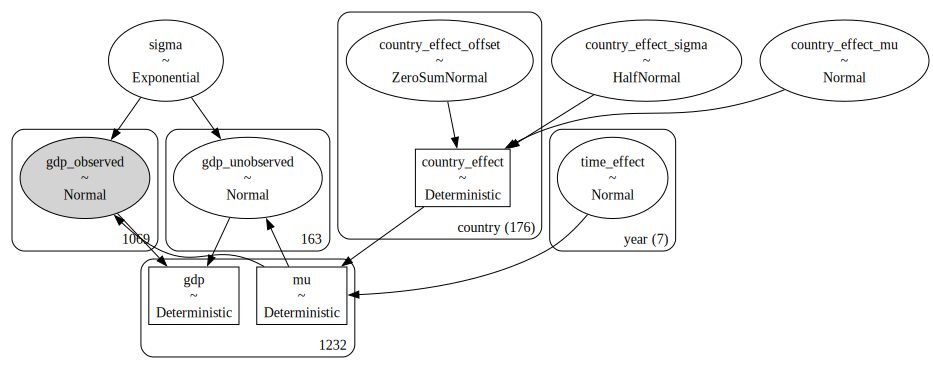

In [125]:
pm.model_to_graphviz(partially_pooled)

In [126]:
with partially_pooled:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [country_effect_mu, country_effect_sigma, country_effect_offset, time_effect, sigma, gdp_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [128]:
az.summary(idata, var_names=['time_effect'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
time_effect[1966-69],1.622,0.503,0.667,2.528,0.010,0.007,2546.0,3002.0,1.0
time_effect[1970-73],1.588,0.509,0.594,2.501,0.010,0.007,2641.0,2931.0,1.0
time_effect[1974-77],0.945,0.493,0.044,1.869,0.009,0.007,2741.0,3208.0,1.0
time_effect[1978-81],0.362,0.496,-0.546,1.293,0.009,0.007,2858.0,3045.0,1.0
time_effect[1982-85],-1.006,0.488,-2.000,-0.172,0.009,0.007,2869.0,3007.0,1.0
time_effect[1986-89],0.113,0.490,-0.817,1.015,0.009,0.007,2682.0,2721.0,1.0
time_effect[1990-93],-2.228,0.480,-3.165,-1.373,0.009,0.006,2820.0,2839.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

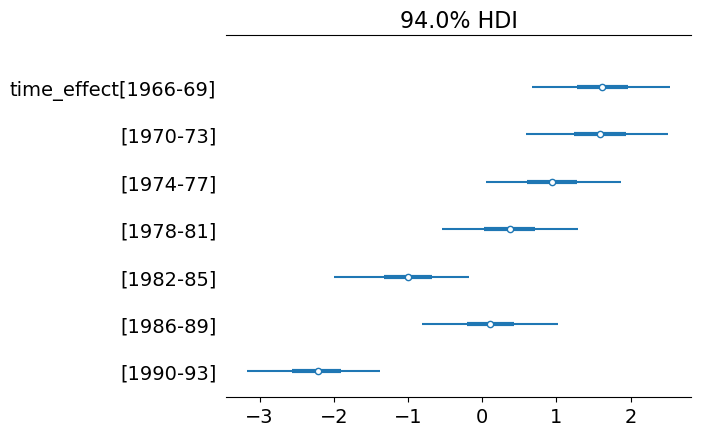

In [131]:
az.plot_forest(idata, var_names=['time_effect'], combined=True)

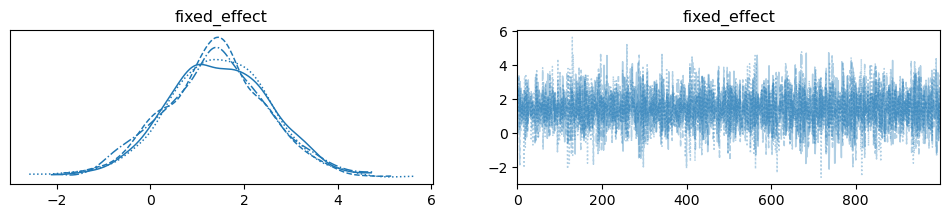

In [102]:
az.plot_trace(idata, var_names=['fixed_effect']);

In [132]:
with partially_pooled:
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True)

/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2C44B3E60>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [gdp_observed]


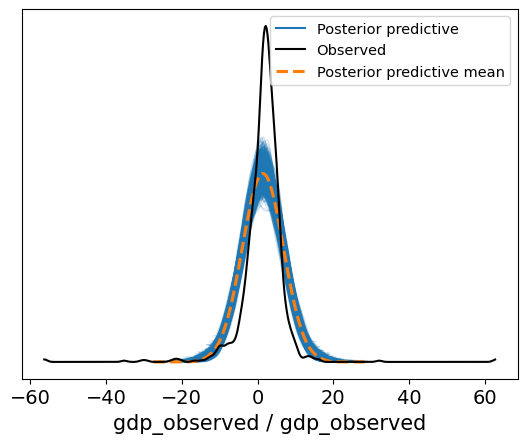

In [133]:
az.plot_ppc(idata);

In [139]:
df.columns

Index(['Index', 'Ident', 'year', 'Country', 'YEAR1', 'CountryYear', 'Country3',
       'Year', 'GDP Growth', 'GDP', 'Budget Surplus', 'Inflation',
       'Trade Openness', 'GOVC', 'Ethnic Frac', 'Assassinations',
       'Institutional Quality', 'L_Money Supply', 'Sub-Saharan Africa',
       'East Asia', 'Log Population', 'Egypt', 'Central America', 'Franc Zone',
       'L_Arms NX', 'DN1900', 'Effective Aid', 'Bilateral Effective Aid',
       'MEDA', 'WBEDA', 'POPDEP'],
      dtype='object')

In [153]:
country_idx, countries = pd.factorize(df.Country3)

In [15]:
factors = ['Inflation', 'Log Population', 'Effective Aid', 'Trade Openness']
labels = ['Year', 'Country3']
wdf = df[factors + labels + ['GDP Growth']].dropna(subset=factors)

obs_idx = wdf.index.values
country_idx, countries = pd.factorize(wdf.Country3)
year_idx, years = pd.factorize(wdf.Year)
coords = {
    'country':countries,
    'year':years,
    'factor':factors,
    'obs_idx':obs_idx
}

In [219]:
with pm.Model(coords=coords) as partially_pooled_w_regression:
    X = pm.MutableData('X', wdf[factors].apply(lambda x: (x - x.mean()) / x.std()), dims=['obs_idx', 'factor'])
    
    country_effect_mu = pm.Normal('country_effect_mu', mu=0, sigma=1)
    country_effect_sigma = pm.HalfNormal('country_effect_sigma', sigma=1)
    country_effect_offset = pm.ZeroSumNormal('country_effect_offset', sigma=1, dims=['country'])
    country_effect = pm.Deterministic('country_effect', country_effect_mu + country_effect_sigma * country_effect_offset,
                                    dims=['country'])

    # Add time effects
    time_effect = pm.Normal('time_effect', mu=0, sigma=1, dims=['year'])

    # Add a regression
    beta_mu = pm.Normal('beta_mu', mu=0, sigma=1, dims=['factor'])
    beta_sigma = pm.HalfNormal('beta_sigma', sigma=1, dims=['factor'])
    beta_offset = pm.ZeroSumNormal('beta_offset', sigma=1, dims=['country', 'factor'])
    beta = pm.Deterministic('beta', beta_mu[None] + beta_sigma[None] * beta_offset, dims=['country', 'factor'])
    # beta = pm.Normal('beta', mu=0, sigma=1, dims=['factor'])
    regression_effect = (X * beta[country_idx]).sum(axis=-1)
    
    mu = pm.Deterministic('mu', country_effect[country_idx] + time_effect[year_idx] + regression_effect, dims=['obs_idx'])
    sigma = pm.Exponential('sigma', lam=1)
    # nu = pm.Uniform('nu', 3, 30)
    gdp_hat = pm.StudentT('GDP Growth', mu=mu, sigma=sigma, nu=7, observed=wdf['GDP Growth'], dims=['obs_idx'])

/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pymc/model/core.py:1357: ImputationWarning: Data in GDP Growth contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [220]:
with partially_pooled_w_regression:
    idata_reg = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [country_effect_mu, country_effect_sigma, country_effect_offset, time_effect, beta_mu, beta_sigma, beta_offset, sigma, GDP Growth_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


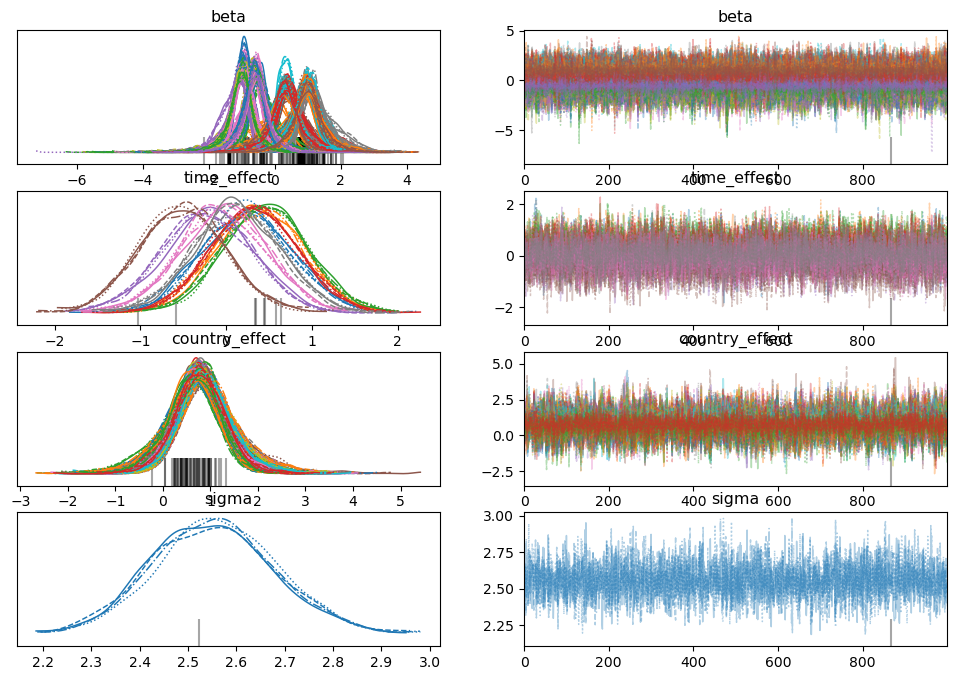

In [221]:
az.plot_trace(idata_reg, var_names=['beta', 'time_effect', 'country_effect', 'sigma']);

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

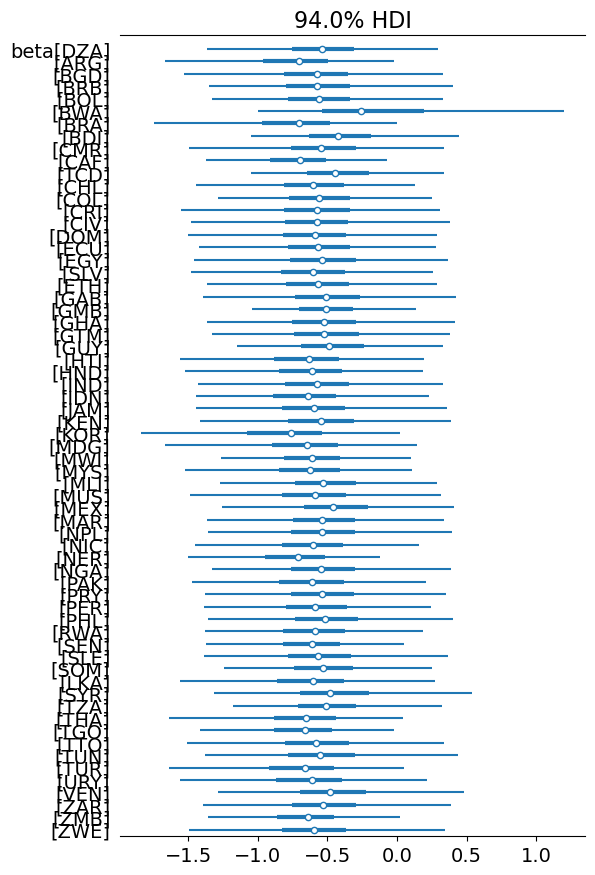

In [223]:
az.plot_forest(idata_reg, 
               var_names=['beta'], 
               coords={'factor':'Effective Aid'},
               combined=True)

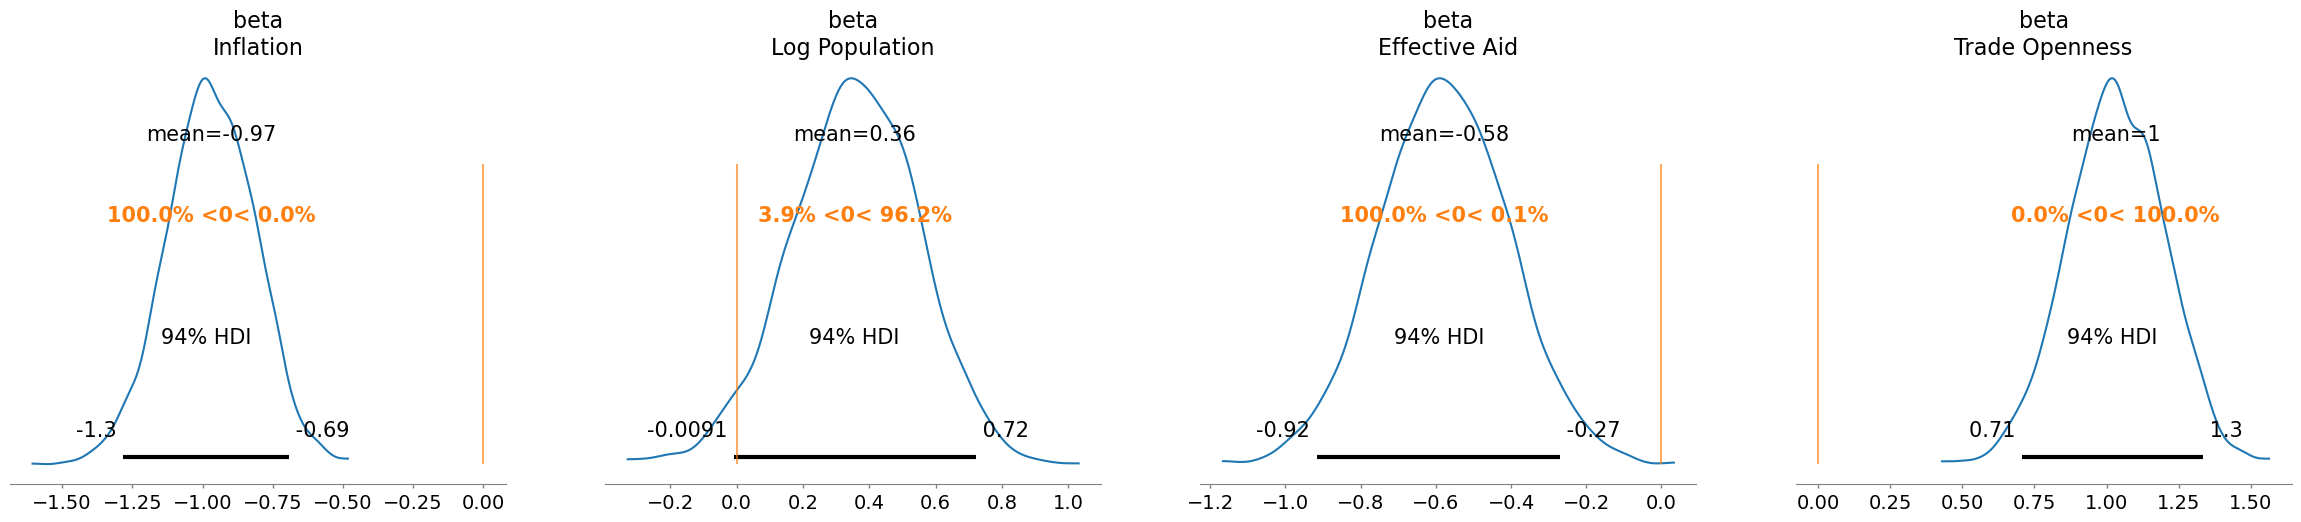

In [212]:
az.plot_posterior(idata_reg, var_names=['beta'], ref_val=0);

In [208]:
with partially_pooled_w_regression:
    idata_reg = pm.sample_posterior_predictive(idata_reg, extend_inferencedata=True)

/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x15FB452A0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [GDP Growth_observed]


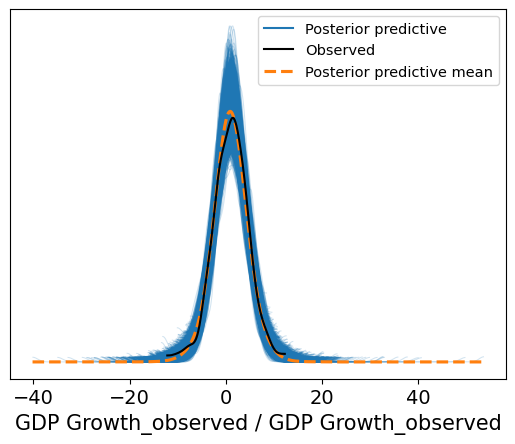

In [209]:
az.plot_ppc(idata_reg);

# Geography

In [102]:
import geopandas as geo
from libpysal.weights import Rook, Queen, KNN, fuzzy_contiguity
year_idx, years = pd.factorize(df.YEAR1)

In [148]:
A = fuzzy_contiguity(merged_df.geometry)
B = KNN.from_dataframe(merged_df, k=3)

/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


In [149]:
import networkx as nx
G = A.to_networkx()
H = B.to_networkx()

In [150]:
nx.adjacency_matrix(G).todense()

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

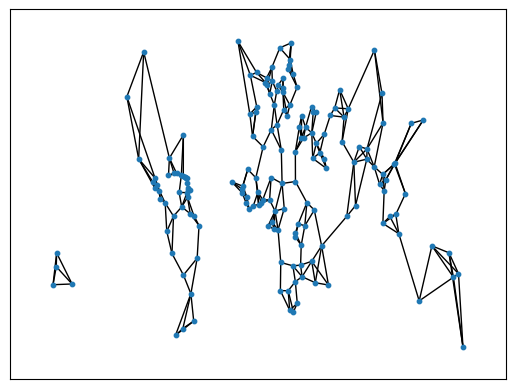

In [151]:
nx.draw_networkx(nx.to_undirected(H), node_size=10, with_labels=False, pos=loc_df.apply(lambda x: (x.x, x.y), axis=1).to_dict())

In [60]:
gdf = geo.read_file('../WB_countries_Admin0_10m/WB_countries_Admin0_10m.shp')

In [110]:
merged_df = pd.merge(gdf, df[df.YEAR1 == years[-1]], left_on='ISO_A3_EH', right_on='Country3')

/var/folders/7b/rzxy96cj0w751_6td3g2yss00000gn/T/ipykernel_66470/1093903267.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  .centroid
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


<Axes: xlabel='x', ylabel='y'>

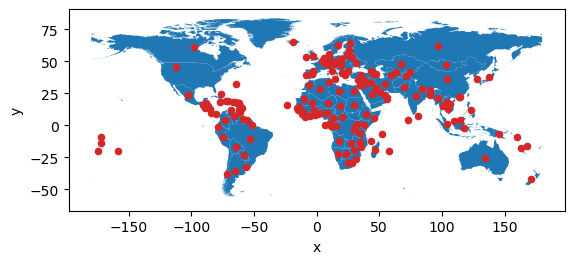

In [111]:
fig, ax = plt.subplots()
gdf.to_crs(4326).plot(ax=ax)
loc_df = (merged_df.to_crs(4326).geometry
     .centroid
     .apply(lambda row: pd.Series({'x':row.x, 'y':row.y})))

(loc_df.plot
     .scatter(x='x', y='y', ax=ax, color='tab:red'))

In [91]:
with pm.Model() as model:
    # Set priors on the hyperparameters of the covariance
    ls = pm.Gamma("ls1", alpha=2, beta=2)
    eta = pm.HalfNormal("eta", sigma=2)

    cov = pm.gp.cov.Matern52(2, ls=ls)  # cov_x1 must accept X1 without error

    # Specify the GP.  The default mean function is `Zero`.
    sigma = pm.Exponential('sigma', lam=1)
    gp = pm.gp.Marginal(cov_func=cov)
    gdp = gp.marginal_likelihood('gdp', X=loc_df.values, y=merged_df['GDP Growth'], sigma=sigma)
    idata = pm.sample()

/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pymc/model/core.py:1357: ImputationWarning: Data in gdp contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ls1, eta, sigma, gdp_unobserved]


ValueError: Not enough samples to build a trace.

In [78]:
z = np.random.multivariate_normal(mean=np.zeros(251), cov=cov(loc_df.values).eval())

In [79]:
loc_df['z'] = z

<Axes: xlabel='x', ylabel='y'>

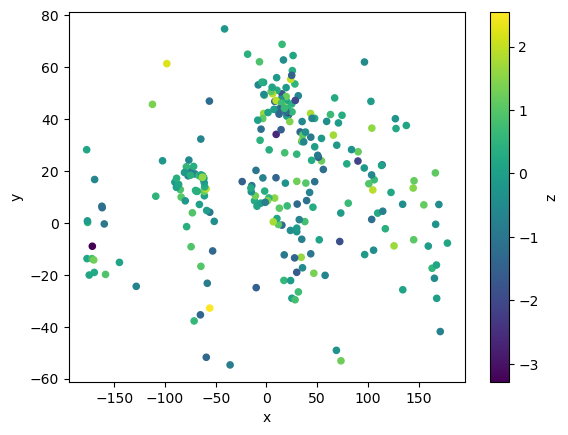

In [81]:
loc_df.plot.scatter(x='x', y='y', c='z')